## Scaling estimates figure

In [30]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('paper')
sns.set_style('white')

In [16]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [18]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 150.0 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh=132.0 # head depth
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Phi(U=0.37,f=9.66E-5,L=6400,R=5000.0,Wsb=13000,N=0.0055):
    ''' flux of upwelling as in Allen and Hickey 2010 , with expected coef of 1/4'''
    f2 = (0.9**(1.5))*((Ro(U,f,R))/(1+(Ro(U,f,R)/0.9)))**(1.5)
    f3 = Ro(U,f,L)**(0.5)
    return(f2*f3)

In [8]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [14]:
select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    records[ind].HCW = dfcan['HCW']
    recordsNoC[ind].HCW = dfnoc['HCW']
    records[ind].TrMass = dfcan['TrMass']
    recordsNoC[ind].TrMass = dfnoc['TrMass']


In [34]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['N_tt06','N_tt08','N_tt10','N_tt12']
key0 = 'N_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    maxd3 = max(df_anom[keys[0]][26:])   
    maxd4 = max(df_anom[keys[1]][26:])   
    maxd5 = max(df_anom[keys[2]][26:])   
    maxd6 = max(df_anom[keys[3]][26:])   
    
    record.maxN = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stdN = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    


In [40]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt06','dTrdz_tt08','dTrdz_tt10','dTrdz_tt12']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][26:])   
    maxd4 = min(df_anom[keys[1]][26:])   
    maxd5 = min(df_anom[keys[2]][26:])   
    maxd6 = min(df_anom[keys[3]][26:])   
    
    
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.inidTrdz = df[key0][30]
    

In [45]:
keys = ['Tr_profile_tt06','Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
        
    maxd3 = np.max(df[keys[0]][26:31])   
    maxd4 = np.max(df[keys[1]][26:31])   
    maxd5 = np.max(df[keys[2]][26:31]) 
    maxd6 = np.max(df[keys[3]][26:31])  
    maxd0 = np.max(df[key0][26:31]) 
    
    
    record.maxTr = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stdTr = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    
    record.maxTr0 = maxd0

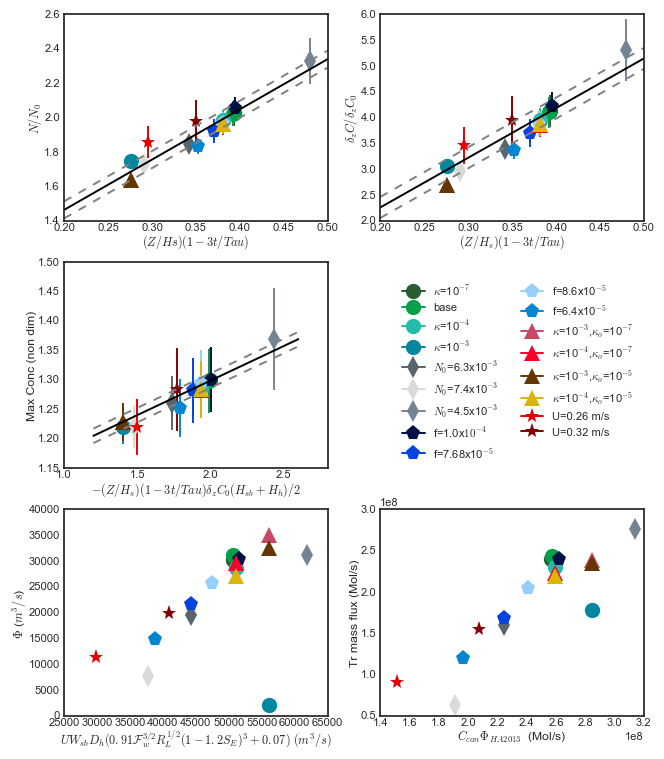

In [54]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,9.05)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

t=4 # days

# No

# dTr/dz
# ax.legend(bbox_to_anchor=(1.3,1)

# Tr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(3*t*24*3600*rec.kv/((Z**2)))
    
    plt1 = ax0.errorbar((Z/Hs)*(TauNo),rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    rec.tauNo = TauNo 
    rec.Z = Z
    #ax0.set_title('Max N below head at Dn')
    ax0.set_ylabel('$N/N_0$',labelpad=0.5)
    ax0.set_xlabel('$(Z/Hs)(1-3t/Tau)$',labelpad=0.5)

# Linear fit
maxN_array_Kv = np.array([rec.maxN/rec.N for rec in records])
tilt_array_Kv = np.array([(rec.Z/Hs)*rec.tauNo for rec in records])

x_fit = np.linspace(0.2, 0.5, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax0.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax0.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(3*t*24*3600*rec.kv/((Z**2)))
    
    plt1 = ax1.errorbar((Z/Hs)*(TauNo),rec.maxdTrdz/rec.inidTrdz,
                       yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    #ax1.set_title('Max $\delta_zC$ below Head depth Dn' )
    ax1.set_ylabel('$\delta_zC/\delta_zC_0$',labelpad=0.5)
    ax1.set_xlabel('$(Z/H_s)(1-3t/Tau)$',labelpad=0.5)

# Linear fit
maxN_array_Kv = np.array([rec.maxdTrdz/rec.inidTrdz for rec in records])
tilt_array_Kv = np.array([((((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N)/Hs)*(1-(3*t*24*3600*rec.kv/((Z**2))))
                          for rec in records])

x_fit = np.linspace(0.2, 0.5, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax1.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k',label='linear fit')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax1.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5', label = 'fit$\pm\sqrt{mean\,sq\,error}$')
lower_bound = ax1.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(3*t*24*3600*rec.kv/((Z**2)))
    
    plt1 = ax2.errorbar(((-(Z/Hs)*(TauNo))*(Hs+Hh)*rec.inidTrdz)/2.0,rec.maxTr/rec.maxTr0,
                   yerr = rec.stdTr/rec.maxTr0,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
   
    #ax2.set_title('Max tracer concetration between head nad sh, Dn')
    ax2.set_ylabel('Max Conc (non dim)',labelpad=0.5)
    ax2.set_xlabel('$-(Z/H_s)(1-3t/Tau)\delta_zC_0(H_{sb}+H_h)/2$',labelpad=0.5)

# Linear fit

maxN_array_Kv = np.array([ rec.maxTr/rec.maxTr0 for rec in records])
tilt_array_Kv = np.array([((-((((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N)/Hs)*(1-(3*t*24*3600*rec.kv/((Z**2)))))*(Hs+Hh)*rec.inidTrdz)/2.0
                          for rec in records])

x_fit = np.linspace(1.2, 2.6, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax2.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k',label='linear fit')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax2.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5', label = 'fit$\pm\sqrt{mean\,sq\,error}$')
lower_bound = ax2.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    

    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-((3*t*24*3600*rec.kv)/(Z**2))

    Napprox=((Z/Hs)*(TauNo))*rec.N

    Se = (s*Napprox)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)

    plt1 = ax4.plot(HA2013*(rec.u*W*Dh(rec.f,L,rec.N)),
                    (((rec.HCW[8]-recNoC.HCW[8])-(rec.HCW[6]-recNoC.HCW[6]))/(time[8]-time[6])),
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)


    #ax4.set_title('Upwelling flux scaled as HA2013 using Napprox')
    ax4.set_ylabel('$\Phi$ ($m^3/s$) ',labelpad=0.5)
    ax4.set_xlabel('$UW_{sb}D_h(0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07)$ $(m^3/s)$',labelpad=0.5)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-((3*t*24*3600*rec.kv)/(Z**2))

    Napprox=((Z/Hs)*(TauNo))*rec.N

    Se = (s*Napprox)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,Napprox))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)

    plt1 = ax5.plot(1000*HA2013*((-(Z/Hs)*(TauNo))*(Hs+Hh)*-0.03598)/2.0,
                    (((rec.TrMass[8]-recNoC.TrMass[8])-(rec.TrMass[6]-recNoC.TrMass[6]))/(time[8]-time[6])),
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)

    #ax5.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$, using N approx')
    ax5.set_xlabel('$C_{can} \Phi_{HA2013}$  (Mol/s)',labelpad=0.5)
    ax5.set_ylabel('Tr mass flux (Mol/s)',labelpad=0.5)

    
ax5.legend(bbox_to_anchor=(1,2.15),ncol=2)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax3.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)
ax5.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax3.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)

plt.savefig('fig_scaling_estimates.pdf',format='pdf')
